# Юсипов Артур ИУ5-24М

#### Короткое описание датасета
> Прокат велосипедов в Лондоне.

Данные в датасете имеют информацию о погодных условиях, дате/времени и количестве велосипедов взятых на прокат в Лондоне за несколько лет

#### Описание анализируемых данных
Год — показывает год, когда велосипед взят в аренду.

Месяц — показывает месяц, когда велосипед взят в аренду.

День — показывает день, когда велосипед взят в аренду.

Время — показывает время в часах, когда велосипед взят в аренду.

Количество велосипедов — отражает количество велосипедов, которые были взяты напрокат.

Температура воздуха  — отражает температуру воздуха в градусах Цельсия.

Ощущаемая температура — отражает температуру воздуха, ощущаемую человеком в градусах Цельсия.

Влажность воздуха — показывает текущую влажность воздуха, выраженную в процентах.

Скорость ветра — показывает скорость ветра в километрах в час.

Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана

Праздничный ли день — отражается в датасете в качестве 0/1.

Выходной ли день — отражается в датасете в качестве 0/1.

Сезон - Spring. Summer. Fall. Winter


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import sklearn

In [76]:
data = pd.read_csv("london_merged.csv")
%matplotlib inline

In [77]:
import random
def set_some_nan(df, index, column):
    if random.random() < 0.3:
        df.at[index, column] = np.NaN

In [78]:
data.loc[data['season']==0, 'season'] = 'spring'
data.loc[data['season']==1, 'season'] = 'summer'
data.loc[data['season']==2, 'season'] = 'fall'
data.loc[data['season']==3, 'season'] = 'winter'


for i in range(data.shape[0]):
    set_some_nan(data, i, 'wind_speed')
    
    
data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))


# Сезон — 0-весна; 1-лето; 2-осень; 3-зима.

In [79]:
data

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,NaN,3.0,0.0,1.0,winter,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,NaN,1.0,0.0,1.0,winter,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,NaN,1.0,0.0,1.0,winter,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,winter,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,winter,4
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,winter,19
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,winter,20
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,NaN,4.0,0.0,0.0,winter,21
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,NaN,4.0,0.0,0.0,winter,22


In [80]:
data_features = list(zip(
# признаки
[i for i in data.columns],
zip(
    # типы колонок
    [str(i) for i in data.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('timestamp', ('object', 0)),
 ('cnt', ('int64', 0)),
 ('t1', ('float64', 0)),
 ('t2', ('float64', 0)),
 ('hum', ('float64', 0)),
 ('wind_speed', ('float64', 5308)),
 ('weather_code', ('float64', 0)),
 ('is_holiday', ('float64', 0)),
 ('is_weekend', ('float64', 0)),
 ('season', ('object', 0)),
 ('hour', ('int64', 0))]

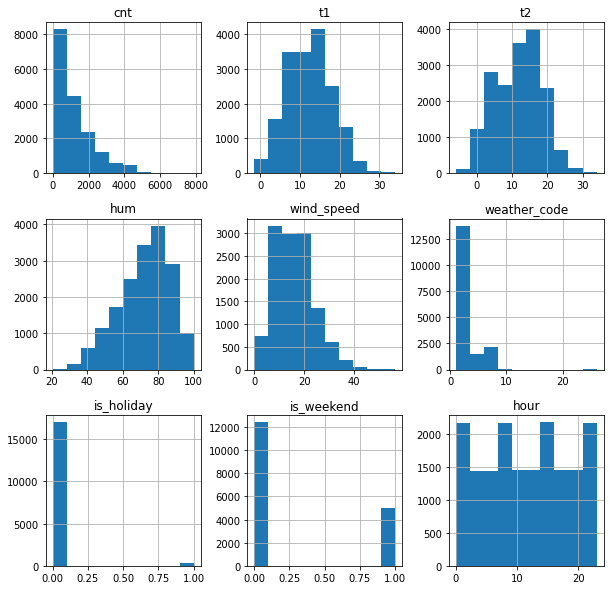

In [81]:
data.hist(figsize=(10,10));

# Устранение пропусков

<AxesSubplot:>

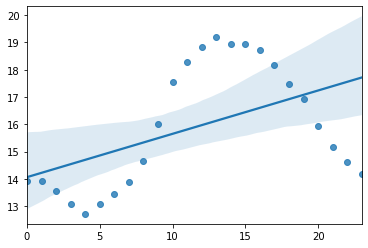

In [82]:
wind_speed_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    wind_speed_avg.append(data[data['hour']==hour]['wind_speed'].mean())

sns.regplot(x=hour_list, y=wind_speed_avg)
# Из диаграммы выше видно, что скорость ветра имеет почти нормальное распределение,
# что даст нам возможность заменить пропуски на средние значения.
# Если мы заполним пропуска средними значениями, то график немного изменится не в самую лучшую сторону.
# Он может потерять свою закономерность от времени суток.

In [123]:
def replace_nan_to_mean(df, index, column, mean):
#     if df.at[index, column] is np.NaN:
    if hash(data.at[index,column]) == 0 and data.at[index,column] != 0:
        df.at[index, column] = mean


In [124]:
mean = data['wind_speed'].mean()
for i in range(data.shape[0]):
    replace_nan_to_mean(data, i, 'wind_speed', mean)


In [125]:
data_features = list(zip(
# признаки
[i for i in data.columns],
zip(
    # типы колонок
    [str(i) for i in data.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('timestamp', ('object', 0)),
 ('cnt', ('int64', 0)),
 ('t1', ('float64', 0)),
 ('t2', ('float64', 0)),
 ('hum', ('float64', 0)),
 ('wind_speed', ('float64', 0)),
 ('weather_code', ('float64', 0)),
 ('is_holiday', ('float64', 0)),
 ('is_weekend', ('float64', 0)),
 ('season', ('object', 0)),
 ('hour', ('int64', 0))]

<AxesSubplot:>

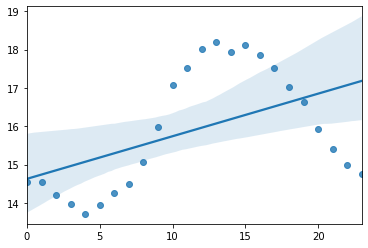

In [126]:
wind_speed_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    wind_speed_avg.append(data[data['hour']==hour]['wind_speed'].mean())

sns.regplot(x=hour_list, y=wind_speed_avg)

# Кодирование категориальных признаков

In [136]:
# seasons = list(zip(list(data['season'].unique()), list(range(len(data['season'].unique())))))
seasons = list(data['season'].unique())
seasons

['winter', 'spring', 'summer', 'fall']

In [140]:
for i in range(data.shape[0]):
    num = seasons.index(data.at[i, 'season'])
    data.at[i, 'season'] = num
#     print(num)


In [141]:
data

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,15.911807,3.0,0.0,1.0,0,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,15.911807,1.0,0.0,1.0,0,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,15.911807,1.0,0.0,1.0,0,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.000000,1.0,0.0,1.0,0,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.500000,1.0,0.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.000000,3.0,0.0,0.0,0,19
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.000000,4.0,0.0,0.0,0,20
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,15.911807,4.0,0.0,0.0,0,21
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,15.911807,4.0,0.0,0.0,0,22


In [142]:
data['season'].unique()

array([0, 1, 2, 3], dtype=object)

# Нормализация числовых признаков

In [143]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

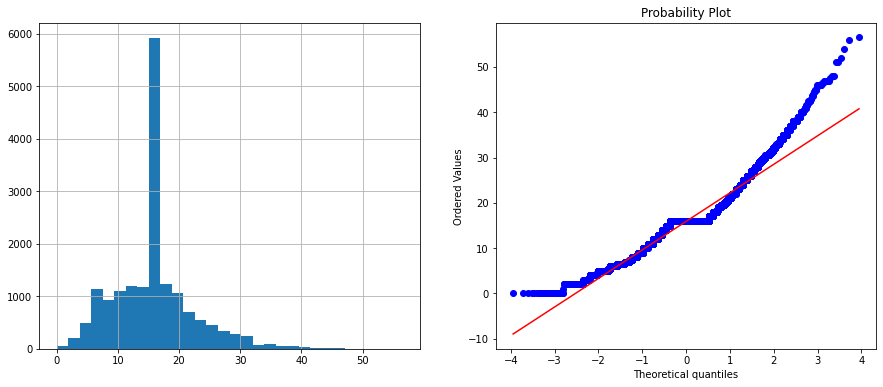

In [144]:
diagnostic_plots(data, 'wind_speed')

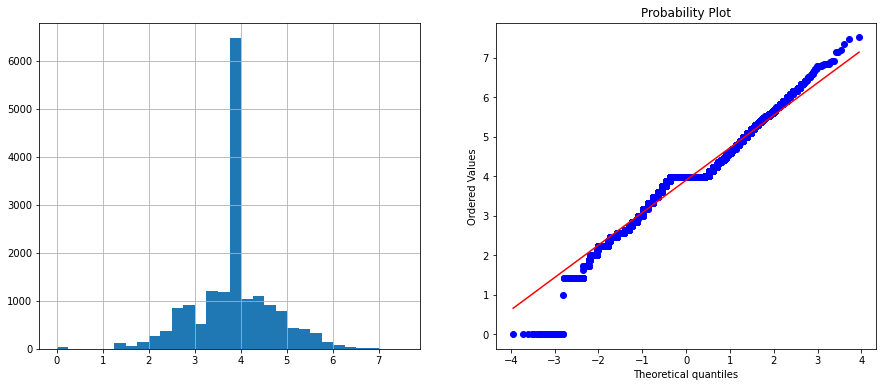

In [145]:
data['wind_speed_sqr'] = data['wind_speed']**(1/2) 
diagnostic_plots(data, 'wind_speed_sqr')